In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Variants/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


In [3]:
learning_rates_list = [1e-3, 1e-4, 1e-5]
patiences_list = [20, 50]
num_layers_list = [1, 2, 4, 8]
batch_sizes_list = [32, 64]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout]
                        i += 1
                        
print(i)

144


In [4]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', 'delta_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

rmse_min = np.inf
best_model = {}

for hyperparameter in tqdm(hyperparameter_dict.values(), desc = '대구_RNN', position = 0):
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    print('-------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 59, 60, 1, batch_size, 'mto')
    

    model = RNN(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers, 
                dropout = dropout, 
                device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_One(train_loader, 
                                                  test_loader, 
                                                  model, 
                                                  criterion, 
                                                  optimizer, 
                                                  num_epochs, 
                                                  patience,
                                                  device)
    
    label_y, predicted = predict_mto(model, df, x_ss, y_ms)
    
    if rmse_min > rmse(label_y[-7:], predicted[-7:]):
        rmse_min = rmse(label_y[-7:], predicted[-7:])
        best_model['RNN'] = [rmse_min, model, loss_list, epoch, lr, patience, 
                             num_layers, batch_size, hidden_size, dropout]

대구_RNN:   0%|          | 0/144 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 145 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 186 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 364 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 576 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 506 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.0020
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 83 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 156 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 172 loss: 0.0025
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 96 loss: 0.0025
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 127 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 58 loss: 0.0113
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 156 loss: 0.0026
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 29 loss: 0.0528
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 22 loss: 0.0525
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 132 loss: 0.0046
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 26 loss: 0.0510
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 172 loss: 0.0037
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 94 loss: 0.0076
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 571 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 312 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 545 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 849 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 602 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 643 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 554 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 190 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 315 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 397 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 275 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 380 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 287 loss: 0.0022
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 252 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 389 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 214 loss: 0.0028
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 454 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 519 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 429 loss: 0.0024
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 357 loss: 0.0021
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 219 loss: 0.0028
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 393 loss: 0.0040
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 354 loss: 0.0016
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 248 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1350 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 923 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1385 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3452 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2545 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1241 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 272 loss: 0.0032
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 158 loss: 0.0053
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 232 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 231 loss: 0.0051
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 201 loss: 0.0024
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 343 loss: 0.0021
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 178 loss: 0.0190
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 291 loss: 0.0039
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 108 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 177 loss: 0.0140
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 120 loss: 0.0142
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 123 loss: 0.0101
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 48 loss: 0.0516
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 196 loss: 0.0117
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 29 loss: 0.0521
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 64 loss: 0.0504
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 64 loss: 0.0510
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 36 loss: 0.0512
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1381 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1644 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1466 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3802 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4237 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1411 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 340 loss: 0.0029
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 542 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 398 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 233 loss: 0.0051
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 367 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 588 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 317 loss: 0.0115
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 183 loss: 0.0135
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 534 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 637 loss: 0.0086
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 452 loss: 0.0035
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 300 loss: 0.0031
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 57 loss: 0.0510
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 123 loss: 0.0523
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 376 loss: 0.0057
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 118 loss: 0.0504
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 378 loss: 0.0083
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 257 loss: 0.0098
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 5718 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4831 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4746 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 9430 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 6852 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 8022 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 122 loss: 0.0545
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 503 loss: 0.0146
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 328 loss: 0.0122
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 490 loss: 0.0160
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 361 loss: 0.0380
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 515 loss: 0.0099
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 162 loss: 0.0502
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 79 loss: 0.0521
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 306 loss: 0.0149
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 246 loss: 0.0515
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 197 loss: 0.0472
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 476 loss: 0.0135
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 185 loss: 0.0524
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 129 loss: 0.0530
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 101 loss: 0.0534
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 293 loss: 0.0502
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 150 loss: 0.0515
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 41 loss: 0.0494
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 9221 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4790 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4825 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 7959 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 6492 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.0512
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 781 loss: 0.0109
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 456 loss: 0.0098
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 716 loss: 0.0121
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 676 loss: 0.0087
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 413 loss: 0.0089
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 255 loss: 0.0508
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 326 loss: 0.0452
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 448 loss: 0.0120
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 279 loss: 0.0495
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 869 loss: 0.0129
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 502 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 206 loss: 0.0517
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 178 loss: 0.0516
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 110 loss: 0.0532
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 186 loss: 0.0509
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.0504
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.0522


In [5]:
best_model

{'RNN': [4.053481905832698,
  RNN(
    (rnn): RNN(3, 8, batch_first=True, dropout=0.25)
    (fc1): Linear(in_features=480, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU()
  ),
  [0.10616245120763779,
   0.10543087869882584,
   0.10470395535230637,
   0.10398267209529877,
   0.10326603800058365,
   0.10255181789398193,
   0.10184080898761749,
   0.10113401710987091,
   0.10043187439441681,
   0.09973514825105667,
   0.09904340654611588,
   0.09835661947727203,
   0.09767688810825348,
   0.09700503945350647,
   0.09634015709161758,
   0.09568115323781967,
   0.09502781182527542,
   0.09438065439462662,
   0.09374010562896729,
   0.09310589730739594,
   0.09247870743274689,
   0.09185831248760223,
   0.09124631434679031,
   0.09064041823148727,
   0.09004251658916473,
   0.0894494578242302,
   0.08886120468378067,
   0.08827817440032959,
   0.08769971132278442,
   0.

In [6]:
save_model(best_model['RNN'][1].state_dict(), "model/Infected/delta/RNN.pth")
save_hyperparameter(best_model['RNN'][3:], "hyperparameter/Infected/delta/RNN.pkl")

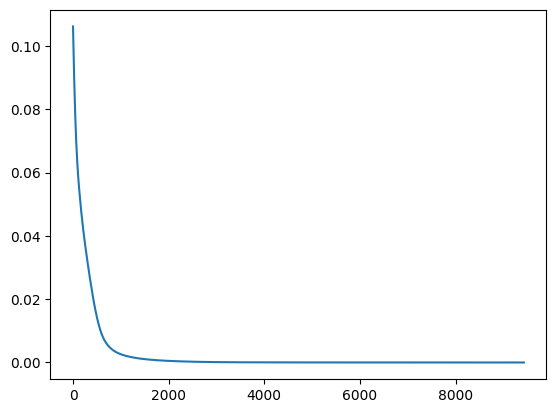

In [7]:
plt.plot(best_model['RNN'][2])

In [8]:
label_y, predicted = predict_mto(best_model['RNN'][1], df, x_ss, y_ms)

4.053481905832698


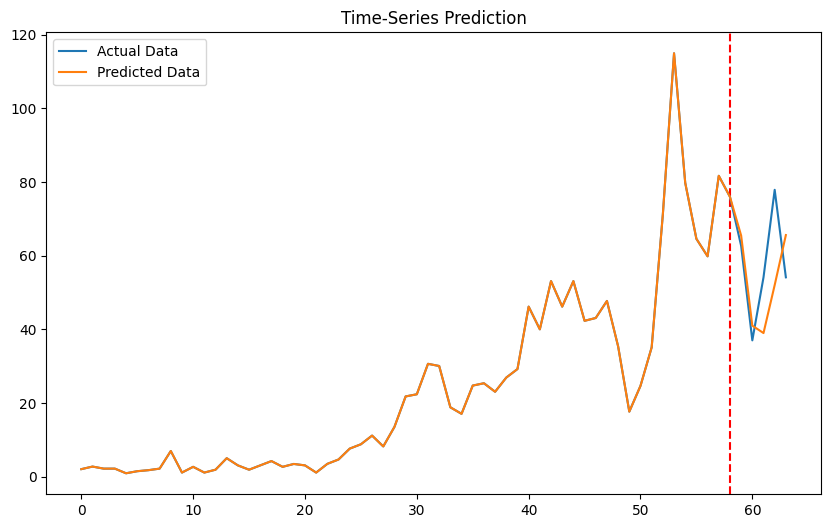

In [9]:
print(rmse(label_y[-7:], predicted[-7:]))
plotting(label_y, predicted, 58)

In [10]:
label_y.shape

(64, 1)